In [100]:
%matplotlib inline

import argparse
import datetime
import json
import logging
import math
import os
import pickle
import time
from typing import Any, Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.sparse as sparse
import torch
import torch.nn as nn
from torch.optim import Adam

U narednoj ćeliji se nalaze pomoćne funkcije i parametri koji će biti korišćeni u nastavku.

In [101]:
CORA_PARAMS = {
    "train_range": [0, 140],
    "val_range": [140, 640],
    "test_range": [1708, 2708],
    "num_features": 1433,
    "num_classes": 7
}


def generate_unique_name() -> str:
    """Generates (unique) name that is used for naming local runs.

    Returns:
        run_name (str): unique name.
    """
    run_name = datetime.datetime.utcnow().strftime("%y-%m-%d-%H-%M-%S-%f")

    return run_name


def make_dir_hierarchy() -> Dict[str, str]:
    """Creating all necessary directories that the current run will use.

    Returns:
        paths (argparse.Namespace): dictionary with created paths and other information.
    """
    run_name = generate_unique_name()

    # directory for storing information of current run
    runs_path = os.path.join("logs", run_name)
    os.makedirs(runs_path, exist_ok=True)

    # directory for storing log (including loss information)
    log_path = os.path.join(runs_path, "log")
    os.makedirs(log_path, exist_ok=True)

    # directory for storing checkpoints
    checkpoints_path = os.path.join(runs_path, "checkpoints")
    os.makedirs(checkpoints_path, exist_ok=True)

    paths = {
        "run_name": run_name,
        "runs_path": runs_path,
        "log_path": log_path,
        "checkpoints_path": checkpoints_path
    }

    return paths


def load_train_config(path: str) -> Dict[str, Any]:
    """Reads JSON config file and returns it.

    Args:
        path (str): config path.

    Returns:
        config (dict): config.
    """
    with open(path, "r") as f:
        config = json.load(f)

    return config


def read_from_binary(path: str):
    """Reads data from binary file.

    Args:
        path (str): path of the binary file.
    """
    with open(path, "rb") as f:
        data = pickle.load(f)

    return data


def normalize_features(features: Union[np.ndarray, sparse.csr.csr_matrix]):
    """Normalize each row to the unit row.

    Args:
        node_features (union): matrix of node features.

    Returns:
        node_features_normalized (union): normalized node features.
    """
    features_sum = np.array(np.sum(features, axis=1))

    features_inv_sum = np.squeeze(1.0 / features_sum)
    features_inv_sum[np.isinf(features_inv_sum)] = 1

    features_inv_sum_diag = sparse.diags(features_inv_sum)
    features_normalized = features_inv_sum_diag.dot(features)

    return features_normalized


def load_cora(data_dir: str, topology_normalization: str):
    """Loads CORA dataset.

    Args:
        data_dir (str): data directory.
        topology_normalization (str): how to normalize topology.

    Returns:
        node_features, node_labels, topology (tuple): pre-processed data.
    """
    # reading raw data
    node_features = read_from_binary(os.path.join(data_dir, "node_features.csr"))
    node_labels = read_from_binary(os.path.join(data_dir, "node_labels.npy"))
    adjacency_list = read_from_binary(os.path.join(data_dir, "adjacency_list.dict"))

    node_features = normalize_features(node_features)

    # making dense adjacency matrix ready for softmax to be applied
    topology = nx.adjacency_matrix(nx.from_dict_of_lists(adjacency_list))
    topology = topology.todense().astype(np.float32)
    # adding loops
    topology += np.identity(topology.shape[0])

    if topology_normalization == "softmax":
        # making topology ready for softmax (-np.inf -> 0; 0 -> 1)
        topology[topology == 0] = -np.inf
        topology[topology == 1] = 0
    elif topology_normalization == "unit":
        topology = normalize_features(topology)

    return node_features, node_labels, topology


def calc_accuracy(preds: torch.Tensor, labels: torch.Tensor) -> float:
    if len(preds.size()) == 2:
        preds = torch.argmax(preds, dim=1)
    elif len(preds.size()) > 2:
        raise RuntimeError("Invalid prediction shape")

    num_hits = torch.sum(preds == labels)
    accuracy = num_hits / labels.size(0)

    return accuracy

/var/folders/70/_h9t67k124s3_3lg_j8b8f700000gn/T/ipykernel_5014/150544233.py:78: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  def normalize_features(features: Union[np.ndarray, sparse.csr.csr_matrix]):


In [102]:
class DropoutWrapper(nn.Module):
    def __init__(self, fn: nn.Module, dropout_prob: float):
        super().__init__()

        self._fn = fn
        self._activation = nn.ReLU()
        self._dropout = nn.Dropout(dropout_prob)

    def forward(self, data):
        topology = data[1]
        output = self._fn(data)[0]
        output = self._dropout(self._activation(output))

        return output, topology


class GraphConvolution(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias=True):
        super().__init__()

        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter("bias", None)

        self._init_params()

    def _init_params(self):
        std = 1.0 / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-std, std)
        if self.bias is not None:
            self.bias.data.uniform_(-std, std)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]):
        x, topology = data
        support = torch.matmul(x, self.weight)
        output = torch.matmul(topology, support)

        if self.bias is not None:
            output += self.bias

        return output, topology


class GCN(nn.Module):
    def __init__(self, num_features_per_layer: List[int], dropout_prob: float):
        super().__init__()

        layers = []
        for prev, curr in zip(num_features_per_layer[:-1: 2], num_features_per_layer[1::2]):
            layers.append(DropoutWrapper(GraphConvolution(prev, curr), dropout_prob))
        layers.append(GraphConvolution(num_features_per_layer[-2], num_features_per_layer[-1]))

        self._net = nn.Sequential(*layers)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]):
        output = self._net(data)

        return output

In [103]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, intermediate_dim: List[int], output_dim: int):
        super().__init__()

        layers = []
        if len(intermediate_dim) == 0:
            layers.append(nn.Linear(input_dim, output_dim))
        else:
            num_neurons = [input_dim] + intermediate_dim
            for prev, curr in zip(num_neurons[:-1], num_neurons[1:]):
                layers.append(nn.Linear(prev, curr))
                layers.append(nn.GELU())

            layers.append(nn.Linear(num_neurons[-1], output_dim))

        self._net = nn.Sequential(*layers)
        self._softmax = nn.Softmax(dim=-1)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        x, topology = data
        output = self._net(x)
        output = self._softmax(output)

        return output, topology

In [104]:
class GATLayer(nn.Module):
    """Class for GAT's elementary layer."""

    def __init__(self, num_in_features: int, num_out_features: int, num_heads: int, dropout_prob: float = 0.6,
                 to_aggregate_heads: bool = False, add_skip_connection: bool = True):
        """Constructor of GAT layer.

        Args:
            num_in_features (int): number of input features.
            num_out_features (int): number of output features.
            num_heads (int): number of attention heads.
            dropout_prob (float): probability of dropout.
            to_aggregate_heads (bool): aggregate features of attention heads (True) or not (False).
            add_skip_connection (bool): to add (True) or not (False) residual/skip connection.
        """
        super().__init__()

        # head's dimension
        self._head_dim = 1
        self._num_in_features = num_in_features
        self._num_out_features = num_out_features
        self._num_heads = num_heads
        self._to_aggregate_heads = to_aggregate_heads
        self._add_skip_connection = add_skip_connection

        # not used during training - only for logging/visualization
        self._attention_weights = None

        # projection and scoring mappings
        self._proj_param = nn.Parameter(torch.Tensor(num_heads, num_in_features, num_out_features))
        self._scoring_source = nn.Parameter(torch.Tensor(num_heads, num_out_features, 1))
        self._scoring_target = nn.Parameter(torch.Tensor(num_heads, num_out_features, 1))

        if add_skip_connection:
            self._skip_proj = nn.Linear(num_in_features, num_heads * num_out_features, bias=False)

        self._activation = nn.LeakyReLU(negative_slope=0.2)
        self._softmax = nn.Softmax(dim=-1)
        self._dropout = nn.Dropout(p=dropout_prob)

        self._init_params()

    def _init_params(self):
        nn.init.xavier_uniform_(self._proj_param)
        nn.init.xavier_uniform_(self._scoring_source)
        nn.init.xavier_uniform_(self._scoring_target)

    def _aggregate_heads(self, attention_weights: torch.Tensor, in_node_features: torch.Tensor, out_node_features: torch.Tensor) \
            -> torch.Tensor:
        """Aggregate features of all attention heads.

        Aggregation is either cocatenation or mean.

        Args:
            attention_weights (torch.Tensor): attention coefficients.
            in_node_features (torch.Tensor): input node features.
            out_node_features (torch.Tensor): output node features.

        Returns:
            out_node_features (torch.Tensor): aggregated node features.
        """
        # for later inspection
        self._attention_weights = attention_weights

        # view will raise an exception if underlying memory isn't contiguous
        if not out_node_features.is_contiguous():
            out_node_features = out_node_features.contiguous()

        if self._add_skip_connection:
            if out_node_features.size(-1) == in_node_features.size(-1):
                out_node_features += in_node_features.unsqueeze(1)
            else:
                out_node_features += self._skip_proj(in_node_features).view(-1, self._num_heads, self._num_out_features)

        if self._to_aggregate_heads:
            out_node_features = out_node_features.view(-1, self._num_heads * self._num_out_features)
        else:
            out_node_features = torch.mean(out_node_features, dim=self._head_dim)

        out_node_features = self._activation(out_node_features)

        return out_node_features

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass.

        Input needs to be fed as a tuple because GAT is defined as a sequential model.

        Args:
            data (tuple): input node features and graph topology.

        Returns:
            out_node_features, topology (tuple): output node features and graph topology.
        """
        in_node_features, topology = data
        num_nodes = in_node_features.shape[0]
        assert topology.shape == (num_nodes, num_nodes), "Adjacency matrix has invalid shape."

        in_node_features = self._dropout(in_node_features)
        node_features_proj = torch.matmul(in_node_features.unsqueeze(0), self._proj_param)
        node_features_proj = self._dropout(node_features_proj)

        edge_scores_source = torch.bmm(node_features_proj, self._scoring_source)
        edge_scores_target = torch.bmm(node_features_proj, self._scoring_target)
        edge_scores = self._activation(edge_scores_source + edge_scores_target.transpose(1, 2))
        attention_weights = self._softmax(edge_scores + topology)

        out_node_features = torch.bmm(attention_weights, node_features_proj)
        out_node_features = out_node_features.transpose(0, 1)

        out_node_features = self._aggregate_heads(attention_weights, in_node_features, out_node_features)

        return out_node_features, topology


class GAT(nn.Module):
    """Class for Graph Attention Network (GAT)."""

    def __init__(self, num_heads_per_layer: List[int], num_features_per_layer: List[int], dropout_prob: float = 0.6,
                 add_skip_connection: bool = True, **kwargs):
        """Constructor of GAT.

        Args:
            num_heads_per_layer (list): number of heads for each layer.
            num_features_per_layer (list): number of features for each layer.
            dropout_prob (float): probability of dropout layer used in GAT's layers.
            add_skip_connection (bool): to add (True) or not (False) residual/skip connection.
        """
        super().__init__()

        num_layers = len(num_heads_per_layer)
        num_heads_per_layer = [1] + num_heads_per_layer

        layers = []
        for i in range(num_layers):
            layer = GATLayer(num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],
                             num_out_features=num_features_per_layer[i + 1],
                             num_heads=num_heads_per_layer[i + 1],
                             to_aggregate_heads=i < num_layers - 1,
                             dropout_prob=dropout_prob,
                             add_skip_connection=add_skip_connection)
            layers.append(layer)

        self._net = nn.Sequential(*layers)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass.

        Input needs to be fed as a tuple because GAT is defined as a sequential model.

        Args:
            data (tuple): input node features and graph topology.

        Returns:
            output (tuple): output node features and graph topology.
        """
        output = self._net(data)

        return output

In [105]:
class Trainer:
    """Class used for training the GAT."""

    def __init__(self, config: Dict[str, Any]):
        """Constructor.

        Args:
            config (dict): configuration of the training, inference and the model.
        """
        self._paths = make_dir_hierarchy()
        self._setup_logger(os.path.join(self._paths["log_path"], "log.txt"))

        with open(os.path.join(self._paths["runs_path"], "config.json"), "w") as f:
            json.dump(config, f, indent=4)

        self._config = config
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        topology_normalization = "unit" if config["model_name"] == "GCN" else "softmax"
        node_features, node_labels, topology = load_cora(config["data_dir"], topology_normalization)
        self._node_features = torch.tensor(node_features.todense(), device=self._device)
        self._node_labels = torch.tensor(node_labels, dtype=torch.long, device=self._device)
        self._topology = torch.tensor(topology, dtype=torch.float32, device=self._device)
        self._indices = {
            "train": torch.arange(*CORA_PARAMS["train_range"], dtype=torch.long, device=self._device),
            "val": torch.arange(*CORA_PARAMS["val_range"], dtype=torch.long, device=self._device),
            "test": torch.arange(*CORA_PARAMS["test_range"], dtype=torch.long, device=self._device)
        }

        if config["model_name"] == "GCN":
            self._model = GCN(**config["model_kwargs"]).to(self._device)
        elif config["model_name"] == "GAT":
            self._model = GAT(**config["model_kwargs"]).to(self._device)
        elif config["model_name"] == "MLP":
            self._model = MLP(**config["model_kwargs"]).to(self._device)

        self._criterion = nn.CrossEntropyLoss()
        self._optimizer = Adam(self._model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

        # saves all metrics and losses during training
        self._aggregator = {}

    def _update_aggregator(self, name: str, value: float) -> None:
        aggregated_values = self._aggregator.get(name, [])
        aggregated_values.append(value)
        self._aggregator[name] = aggregated_values

    def _setup_logger(self, log_path: str) -> None:
        """Setup logging to print logs to both file and stdout.

        Timestamps are in GMT format due to lexicographic order. Example: 22-01-27-21-09-48.

        Args:
            log_path (str): path of log file.
        """
        logging.basicConfig(
            level=logging.INFO,
            format="%(asctime)s: [%(levelname)s] %(message)s",
            datefmt="%y-%m-%d %H:%M:%S",
            handlers=[
                logging.FileHandler(log_path),
                logging.StreamHandler()
            ]
        )
        logging.Formatter.converter = time.gmtime

    def _prepare_log(self, epoch, ce, acc, name):
        epoch_length = len(str(self._config["epochs"]))
        total_length = len(f"epoch=[{self._config['epochs']}/{self._config['epochs']}]:")
        epoch_log = f"epoch=[{epoch:>{epoch_length}}/{self._config['epochs']}]:"
        ce_log = f"CE_{name}={ce:.5f}"
        acc_log = f"ACC_{name}={acc:.2%}"
        log = f"{epoch_log:<{total_length}} {ce_log:>16} {acc_log:>16}"

        return log

    def run_training(self):
        train_labels = self._node_labels.index_select(0, self._indices["train"])
        train_indices = self._indices["train"]
        graph_data = (self._node_features, self._topology)

        for epoch in range(1, self._config["epochs"] + 1):
            self._model.train()
            self._optimizer.zero_grad()

            pred_labels = self._model(graph_data)[0].index_select(0, train_indices)
            loss = self._criterion(pred_labels, train_labels)
            accuracy = calc_accuracy(pred_labels, train_labels)

            logging.info(self._prepare_log(epoch, loss.item(), accuracy, "train"))
            self._update_aggregator("CE_train", (epoch, loss.item()))
            self._update_aggregator("ACC_train", (epoch, accuracy))

            loss.backward()
            self._optimizer.step()

            if epoch % self._config["ckpt_freq"] == 0:
                self._dump_model(epoch)

            if epoch == 1 or epoch % self._config["val_freq"] == 0:
                self._run_val(epoch)

            if epoch == 1 or epoch % self._config["test_freq"] == 0:
                self._run_test(epoch)

    def _run_val(self, epoch: int):
        val_labels = self._node_labels.index_select(0, self._indices["val"])
        val_indices = self._indices["val"]
        graph_data = (self._node_features, self._topology)

        self._model.eval()
        pred_labels = self._model(graph_data)[0].index_select(0, val_indices)
        loss = self._criterion(pred_labels, val_labels)
        accuracy = calc_accuracy(pred_labels, val_labels)

        logging.info(self._prepare_log(epoch, loss.item(), accuracy, "val"))
        self._update_aggregator("CE_val", (epoch, loss.item()))
        self._update_aggregator("ACC_val", (epoch, accuracy))

    def _run_test(self, epoch: int):
        test_labels = self._node_labels.index_select(0, self._indices["test"])
        test_indices = self._indices["test"]
        graph_data = (self._node_features, self._topology)

        self._model.eval()
        pred_labels = self._model(graph_data)[0].index_select(0, test_indices)
        loss = self._criterion(pred_labels, test_labels)
        accuracy = calc_accuracy(pred_labels, test_labels)

        logging.info(self._prepare_log(epoch, loss.item(), accuracy, "test"))
        self._update_aggregator("CE_test", (epoch, loss.item()))
        self._update_aggregator("ACC_test", (epoch, accuracy))

    def _dump_model(self, epoch: int) -> None:
        """Dumps current checkpoint.

        Args:
            epoch (int): current epoch.
        """
        ckpt_path = os.path.join(self._paths["checkpoints_path"], f"gat_{epoch}.ckpt")
        torch.save(self._model.state_dict(), ckpt_path)

    @property
    def aggregator(self) -> Dict[str, Any]:
        """Getter for aggregator."""
        return self._aggregator

    @property
    def model(self) -> nn.Module:
        """Getter for model."""
        return self._model

In [106]:
config_gcn = {
    "model_name": "GCN",
    "data_dir": "data",
    "epochs": 200,
    "lr": 0.01,
    "weight_decay": 0.0005,
    "model_kwargs": {
        "num_features_per_layer": [1433, 16, 7],
        "dropout_prob": 0.5
    },
    "ckpt_freq": 100,
    "val_freq": 10,
    "test_freq": 10
}

trainer_gcn = Trainer(config_gcn)
trainer_gcn.run_training()

/var/folders/70/_h9t67k124s3_3lg_j8b8f700000gn/T/ipykernel_5014/150544233.py:73: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  data = pickle.load(f)
/var/folders/70/_h9t67k124s3_3lg_j8b8f700000gn/T/ipykernel_5014/150544233.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  topology = nx.adjacency_matrix(nx.from_dict_of_lists(adjacency_list))
22-06-17 02:10:14: [INFO] epoch=[  1/200]: CE_train=1.95990 ACC_train=15.00%
22-06-17 02:10:14: [INFO] epoch=[  1/200]:   CE_val=1.96878   ACC_val=15.60%
22-06-17 02:10:14: [INFO] epoch=[  1/200]:  CE_test=1.97184  ACC_test=14.40%
22-06-17 02:10:14: [INFO] epoch=[  2/200]: CE_train=1.95328 ACC_train=15.00%
22-06-17 02:10:14: [INFO] epoch=[  3/200]: CE_train=1.94239 ACC_train=14.29%
22-06-17 02:10:14: [INFO] epoch=[  4/200]: CE_train=1.93841 ACC_train=16.43%
22-06-17 02:10:14: [INFO] epoch=[  5/200]: CE_trai

22-06-17 02:10:18: [INFO] epoch=[ 84/200]: CE_train=0.80077 ACC_train=95.00%
22-06-17 02:10:18: [INFO] epoch=[ 85/200]: CE_train=0.84868 ACC_train=91.43%
22-06-17 02:10:18: [INFO] epoch=[ 86/200]: CE_train=0.80498 ACC_train=90.71%
22-06-17 02:10:18: [INFO] epoch=[ 87/200]: CE_train=0.87907 ACC_train=87.86%
22-06-17 02:10:18: [INFO] epoch=[ 88/200]: CE_train=0.79104 ACC_train=95.00%
22-06-17 02:10:18: [INFO] epoch=[ 89/200]: CE_train=0.78254 ACC_train=91.43%
22-06-17 02:10:18: [INFO] epoch=[ 90/200]: CE_train=0.76552 ACC_train=90.71%
22-06-17 02:10:18: [INFO] epoch=[ 90/200]:   CE_val=1.12781   ACC_val=80.60%
22-06-17 02:10:18: [INFO] epoch=[ 90/200]:  CE_test=1.09824  ACC_test=81.30%
22-06-17 02:10:18: [INFO] epoch=[ 91/200]: CE_train=0.73012 ACC_train=92.14%
22-06-17 02:10:18: [INFO] epoch=[ 92/200]: CE_train=0.74535 ACC_train=91.43%
22-06-17 02:10:18: [INFO] epoch=[ 93/200]: CE_train=0.72517 ACC_train=91.43%
22-06-17 02:10:18: [INFO] epoch=[ 94/200]: CE_train=0.74980 ACC_train=90.71%

22-06-17 02:10:22: [INFO] epoch=[173/200]: CE_train=0.35824 ACC_train=95.71%
22-06-17 02:10:22: [INFO] epoch=[174/200]: CE_train=0.37370 ACC_train=96.43%
22-06-17 02:10:22: [INFO] epoch=[175/200]: CE_train=0.36720 ACC_train=96.43%
22-06-17 02:10:22: [INFO] epoch=[176/200]: CE_train=0.36142 ACC_train=95.71%
22-06-17 02:10:22: [INFO] epoch=[177/200]: CE_train=0.34425 ACC_train=97.14%
22-06-17 02:10:22: [INFO] epoch=[178/200]: CE_train=0.34837 ACC_train=98.57%
22-06-17 02:10:22: [INFO] epoch=[179/200]: CE_train=0.32203 ACC_train=97.14%
22-06-17 02:10:22: [INFO] epoch=[180/200]: CE_train=0.34430 ACC_train=97.14%
22-06-17 02:10:22: [INFO] epoch=[180/200]:   CE_val=0.76315   ACC_val=80.80%
22-06-17 02:10:22: [INFO] epoch=[180/200]:  CE_test=0.72233  ACC_test=82.60%
22-06-17 02:10:22: [INFO] epoch=[181/200]: CE_train=0.33050 ACC_train=97.86%
22-06-17 02:10:22: [INFO] epoch=[182/200]: CE_train=0.35454 ACC_train=95.00%
22-06-17 02:10:22: [INFO] epoch=[183/200]: CE_train=0.36803 ACC_train=94.29%

In [107]:
config_gat = {
    "model_name": "GAT",
    "data_dir": "data",
    "epochs": 200,
    "lr": 0.005,
    "weight_decay": 0.0005,
    "model_kwargs": {
        "num_heads_per_layer": [8, 1],
        "add_skip_connection": False,
        "num_features_per_layer": [1433, 8, 7],
        "dropout_prob": 0.6
    },
    "ckpt_freq": 100,
    "val_freq": 10,
    "test_freq": 10
}

trainer_gat = Trainer(config_gat)
trainer_gat.run_training()

/var/folders/70/_h9t67k124s3_3lg_j8b8f700000gn/T/ipykernel_5014/150544233.py:73: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  data = pickle.load(f)
/var/folders/70/_h9t67k124s3_3lg_j8b8f700000gn/T/ipykernel_5014/150544233.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  topology = nx.adjacency_matrix(nx.from_dict_of_lists(adjacency_list))
22-06-17 02:10:24: [INFO] epoch=[  1/200]: CE_train=1.94615  ACC_train=8.57%
22-06-17 02:10:24: [INFO] epoch=[  1/200]:   CE_val=1.94572   ACC_val=21.20%
22-06-17 02:10:25: [INFO] epoch=[  1/200]:  CE_test=1.94571  ACC_test=23.50%
22-06-17 02:10:25: [INFO] epoch=[  2/200]: CE_train=1.94506 ACC_train=35.71%
22-06-17 02:10:26: [INFO] epoch=[  3/200]: CE_train=1.94482 ACC_train=35.00%
22-06-17 02:10:27: [INFO] epoch=[  4/200]: CE_train=1.94393 ACC_train=40.71%
22-06-17 02:10:27: [INFO] epoch=[  5/200]: CE_trai

22-06-17 02:11:23: [INFO] epoch=[ 84/200]: CE_train=1.36117 ACC_train=68.57%
22-06-17 02:11:24: [INFO] epoch=[ 85/200]: CE_train=1.27932 ACC_train=65.71%
22-06-17 02:11:24: [INFO] epoch=[ 86/200]: CE_train=1.28213 ACC_train=67.86%
22-06-17 02:11:25: [INFO] epoch=[ 87/200]: CE_train=1.34051 ACC_train=63.57%
22-06-17 02:11:25: [INFO] epoch=[ 88/200]: CE_train=1.24149 ACC_train=70.00%
22-06-17 02:11:26: [INFO] epoch=[ 89/200]: CE_train=1.24940 ACC_train=67.14%
22-06-17 02:11:27: [INFO] epoch=[ 90/200]: CE_train=1.29730 ACC_train=66.43%
22-06-17 02:11:27: [INFO] epoch=[ 90/200]:   CE_val=1.42390   ACC_val=81.00%
22-06-17 02:11:28: [INFO] epoch=[ 90/200]:  CE_test=1.41338  ACC_test=80.90%
22-06-17 02:11:28: [INFO] epoch=[ 91/200]: CE_train=1.25008 ACC_train=70.00%
22-06-17 02:11:28: [INFO] epoch=[ 92/200]: CE_train=1.34091 ACC_train=62.86%
22-06-17 02:11:29: [INFO] epoch=[ 93/200]: CE_train=1.24945 ACC_train=68.57%
22-06-17 02:11:30: [INFO] epoch=[ 94/200]: CE_train=1.18315 ACC_train=65.00%

22-06-17 02:12:23: [INFO] epoch=[173/200]: CE_train=0.86436 ACC_train=75.00%
22-06-17 02:12:23: [INFO] epoch=[174/200]: CE_train=0.98564 ACC_train=69.29%
22-06-17 02:12:24: [INFO] epoch=[175/200]: CE_train=0.72956 ACC_train=80.00%
22-06-17 02:12:24: [INFO] epoch=[176/200]: CE_train=0.71702 ACC_train=78.57%
22-06-17 02:12:25: [INFO] epoch=[177/200]: CE_train=0.93279 ACC_train=69.29%
22-06-17 02:12:26: [INFO] epoch=[178/200]: CE_train=0.73085 ACC_train=77.86%
22-06-17 02:12:26: [INFO] epoch=[179/200]: CE_train=0.79681 ACC_train=71.43%
22-06-17 02:12:27: [INFO] epoch=[180/200]: CE_train=0.68014 ACC_train=79.29%
22-06-17 02:12:27: [INFO] epoch=[180/200]:   CE_val=1.16656   ACC_val=79.60%
22-06-17 02:12:28: [INFO] epoch=[180/200]:  CE_test=1.13512  ACC_test=82.10%
22-06-17 02:12:28: [INFO] epoch=[181/200]: CE_train=0.94324 ACC_train=71.43%
22-06-17 02:12:29: [INFO] epoch=[182/200]: CE_train=0.76834 ACC_train=75.71%
22-06-17 02:12:29: [INFO] epoch=[183/200]: CE_train=0.79205 ACC_train=75.71%

In [108]:
config_mlp = {
    "model_name": "MLP",
    "data_dir": "data",
    "epochs": 100,
    "lr": 0.01,
    "weight_decay": 0.0005,
    "model_kwargs": {
        "input_dim": 1433,
        "intermediate_dim": [4096],
        "output_dim": 7
    },
    "ckpt_freq": 100,
    "val_freq": 10,
    "test_freq": 10
}

trainer_mlp = Trainer(config_mlp)
trainer_mlp.run_training()

/var/folders/70/_h9t67k124s3_3lg_j8b8f700000gn/T/ipykernel_5014/150544233.py:73: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  data = pickle.load(f)
/var/folders/70/_h9t67k124s3_3lg_j8b8f700000gn/T/ipykernel_5014/150544233.py:116: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  topology = nx.adjacency_matrix(nx.from_dict_of_lists(adjacency_list))
22-06-17 02:12:42: [INFO] epoch=[  1/100]: CE_train=1.94588 ACC_train=14.29%
22-06-17 02:12:44: [INFO] epoch=[  1/100]:   CE_val=1.94590   ACC_val=25.80%
22-06-17 02:12:44: [INFO] epoch=[  1/100]:  CE_test=1.94585  ACC_test=22.50%
22-06-17 02:12:45: [INFO] epoch=[  2/100]: CE_train=1.94437 ACC_train=53.57%
22-06-17 02:12:47: [INFO] epoch=[  3/100]: CE_train=1.94319 ACC_train=26.43%
22-06-17 02:12:48: [INFO] epoch=[  4/100]: CE_train=1.94015 ACC_train=19.29%
22-06-17 02:12:50: [INFO] epoch=[  5/100]: CE_trai

22-06-17 02:15:09: [INFO] epoch=[ 84/100]: CE_train=1.49943 ACC_train=71.43%
22-06-17 02:15:10: [INFO] epoch=[ 85/100]: CE_train=1.49879 ACC_train=71.43%
22-06-17 02:15:12: [INFO] epoch=[ 86/100]: CE_train=1.49894 ACC_train=71.43%
22-06-17 02:15:14: [INFO] epoch=[ 87/100]: CE_train=1.49936 ACC_train=71.43%
22-06-17 02:15:15: [INFO] epoch=[ 88/100]: CE_train=1.49979 ACC_train=71.43%
22-06-17 02:15:17: [INFO] epoch=[ 89/100]: CE_train=1.49970 ACC_train=71.43%
22-06-17 02:15:18: [INFO] epoch=[ 90/100]: CE_train=1.49956 ACC_train=71.43%
22-06-17 02:15:20: [INFO] epoch=[ 90/100]:   CE_val=1.79128   ACC_val=48.00%
22-06-17 02:15:21: [INFO] epoch=[ 90/100]:  CE_test=1.76832  ACC_test=51.00%
22-06-17 02:15:21: [INFO] epoch=[ 91/100]: CE_train=1.49968 ACC_train=71.43%
22-06-17 02:15:23: [INFO] epoch=[ 92/100]: CE_train=1.50146 ACC_train=71.43%
22-06-17 02:15:25: [INFO] epoch=[ 93/100]: CE_train=1.50167 ACC_train=71.43%
22-06-17 02:15:26: [INFO] epoch=[ 94/100]: CE_train=1.49822 ACC_train=71.43%

In [109]:
def plot_metrics(aggregator: Dict[str, List[Tuple[float, float]]], metric_name: str, axis):
    metric_name = metric_name.upper()
    suffixes = ["train", "val", "test"]
    colors = ["blue", "green", "red"]

    for suffix, color in zip(suffixes, colors):
        name = f"{metric_name}_{suffix}"
        metric_values = aggregator[name]
        x_coords = list(map(lambda p: p[0], metric_values))
        y_coords = list(map(lambda p: p[1], metric_values))

        axis.plot(x_coords, y_coords, label=suffix, color=color)

    axis.legend(loc="upper right")
    axis.set_title(metric_name)
    axis.grid()

Prikaz funkcije gubitka i tačnosti tokom treninga, validacije i testa.

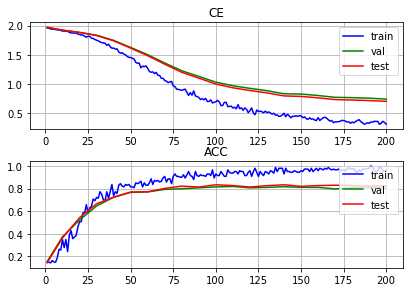

In [110]:
aggregator = trainer_gcn.aggregator
fig, axes = plt.subplots(2)
fig.tight_layout()

# plotting loss
plot_metrics(aggregator, "CE", axes[0])
# plotting accuracy
plot_metrics(aggregator, "ACC", axes[1])

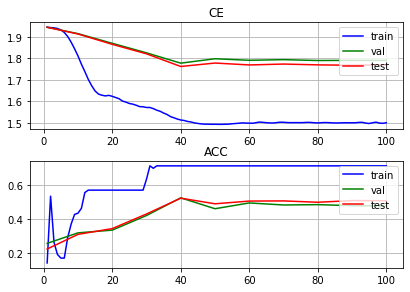

In [111]:
aggregator = trainer_mlp.aggregator
fig, axes = plt.subplots(2)
fig.tight_layout()

# plotting loss
plot_metrics(aggregator, "CE", axes[0])
# plotting accuracy
plot_metrics(aggregator, "ACC", axes[1])

Nakon što smo istrenirali GAT model, možemo izvršiti različite vizualizacije iz kojih ćemo izvesti korisne zaključke.
Uradićemo tri različite vizualizacije:
1. Vizualizacija podataka u latentnom prostoru GAT modela, koristeći t-SNE,
2. Vizualizacija vrednosti koeficijenata pažnje pomoću entropije, pri čemu će biti upoređeni sa uniformnom raspodelom
3. Vizualizacija koeficijenata pažnje gde ćemo prikazati čvorove grafa sa svojim susedima, pri čemu će debljine grana biti proporcionalne koeficijentima pažnje.

t-SNE je algoritam za smanjivanje dimenzija podataka koji se oslanja na topološku analizu podataka. U latentnom prostoru GAT modela svaki čvor ima 7 atributa (jer imamo 7 različitih klasa), pa je cilj da, koristeći t-SNE, preslikamo 7-dimenzioni prostor u 2-dimenzioni koji možemo da plotujemo.

GAT model sa jednakim koeficijentima pažnje se može tumačiti kao obična konvolutivna grafovska mreža. Odnosno skup modela grafovske konvolutivne mreže se može smatrati podskupom skupa GAT modela. Zato je ideja da pomoću druge i treće vizualizacija uporedimo koliko se raspodela koeficijenata pažnje razlikuje od uniformne raspodele. Što se više razlikuje, to se GAT model više razlikuje od konvolutivne grafovske mreže.



In [112]:
from sklearn.manifold import TSNE
from scipy.stats import entropy

Prvo ćemo definisati pomoćnu funkciju čiji je ulaz objekat klase Trainer, a izlazne vrednosti su vrednosti atributa pre primene softmax funkcije u poslednjem skrivenom sloju, skup grana grafa, labele čvorova i GAT model.

In [ ]:
def gat_forward_pass(trainer):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

    gat = trainer.model
    node_features = trainer._node_features
    node_labels = trainer._node_labels
    topology = trainer._topology
    gat.eval()
    
    with torch.no_grad():
        # Run predictions and collect the data before softmax function
        all_nodes_unnormalized_scores, _ = gat((node_features, topology))  # shape = (num of nodes, num of classes)
        all_nodes_unnormalized_scores = all_nodes_unnormalized_scores.cpu().numpy()
        
    return all_nodes_unnormalized_scores, topology, node_labels, gat

Zatim imamo i pomoćnu funkciju za iscrtavanje histograma. Hoćemo da iscrtamo histograme za vrednosti koeficijente pažnje i za uniformnu raspodelu, pa taj izbor pravimo pomoću parametra uniform_distribution.

In [118]:
def draw_entropy_histogram(entropy_array, title, color='blue', uniform_distribution=False, num_bins=30):
    max_value = np.max(entropy_array)
    bar_width = (max_value / num_bins) * (1.0 if uniform_distribution else 0.75)
    histogram_values, histogram_bins = np.histogram(entropy_array, bins=num_bins, range=(0.0, max_value))

    plt.bar(histogram_bins[:num_bins], histogram_values[:num_bins], width=bar_width, color=color)
    plt.xlabel(f'entropy bins')
    plt.ylabel(f'# of node neighborhoods')
    plt.title(title)

Konačno, definišemo glavnu funkciju za vizualizaciju modela. Pomoću parametra visualization_type biramo tip vizualizacije ('tsne' ili 'entropy').

In [165]:
def visualize_gat_properties(trainer, visualization_type):
    all_nodes_unnormalized_scores, topology, node_labels, gat = gat_forward_pass(trainer)
    if visualization_type == 'tsne':
        node_labels = node_labels.cpu().numpy()
        num_classes = len(set(node_labels)) # = 7
        
        # n_components is dimension of  the embedded space
        # perplexity is related to the number of nearest neighbors that is used in algorithm.
        # perplexity is usually between 5 and 50, different values can result in significantly different results
        t_sne_embeddings = TSNE(n_components=2, perplexity=30).fit_transform(all_nodes_unnormalized_scores)

        fig = plt.figure(figsize=(12,8), dpi=100)  
        for class_id in range(num_classes):
            # We extract the points whose true label equals class_id and we color them in the same way
            plt.scatter(t_sne_embeddings[node_labels == class_id, 0], t_sne_embeddings[node_labels == class_id, 1], s=20, color={0: "yellow", 1: "red", 2: "green", 3: "orange", 4: "pink", 5: "blue", 6: "gray"}[class_id], edgecolors='black', linewidths=0.2)
        plt.show()
        
    elif visualization_type == 'entropy':
        num_heads_per_layer = [layer._num_heads for layer in gat._net]
        num_layers = len(num_heads_per_layer)

        num_of_nodes = len(node_labels)
        target_node_ids = topology[1].cpu().numpy()
        # For every GAT layer and for every GAT attention head plot the entropy histogram
        for layer_id in range(num_layers):
            # Fetch the attention weights for edges (attention is logged during GAT's forward pass above)
            # attention shape = (N, NH, 1) -> (N, NH) - we just squeeze the last dim it's superfluous
            all_attention_weights = gat._net[layer_id]._attention_weights.squeeze(dim=-1).cpu().numpy()

            for head_id in range(num_heads_per_layer[layer_id]):
                uniform_dist_entropy_list = []  # save the ideal uniform histogram as the reference
                neighborhood_entropy_list = []

                
                for target_node_id in range(num_of_nodes):  # find every the neighborhood for every node in the graph
                    # These attention weights sum up to 1 by GAT design so we can treat it as a probability distribution
                    neigborhood_attention = all_attention_weights[target_node_ids == target_node_id].flatten()
                    # Reference uniform distribution of the same length
                    ideal_uniform_attention = np.ones(len(neigborhood_attention))/len(neigborhood_attention)

                    neighborhood_entropy_list.append(entropy(neigborhood_attention, base=2))
                    uniform_dist_entropy_list.append(entropy(ideal_uniform_attention, base=2))

                title = f'Cora entropy histogram layer={layer_id}, attention head={head_id}'
                draw_entropy_histogram(uniform_dist_entropy_list, title, color='darkseagreen', uniform_distribution=True)
                draw_entropy_histogram(neighborhood_entropy_list, title, color='crimson')
                plt.show()
                plt.close()

/Users/msrbakoski/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/msrbakoski/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


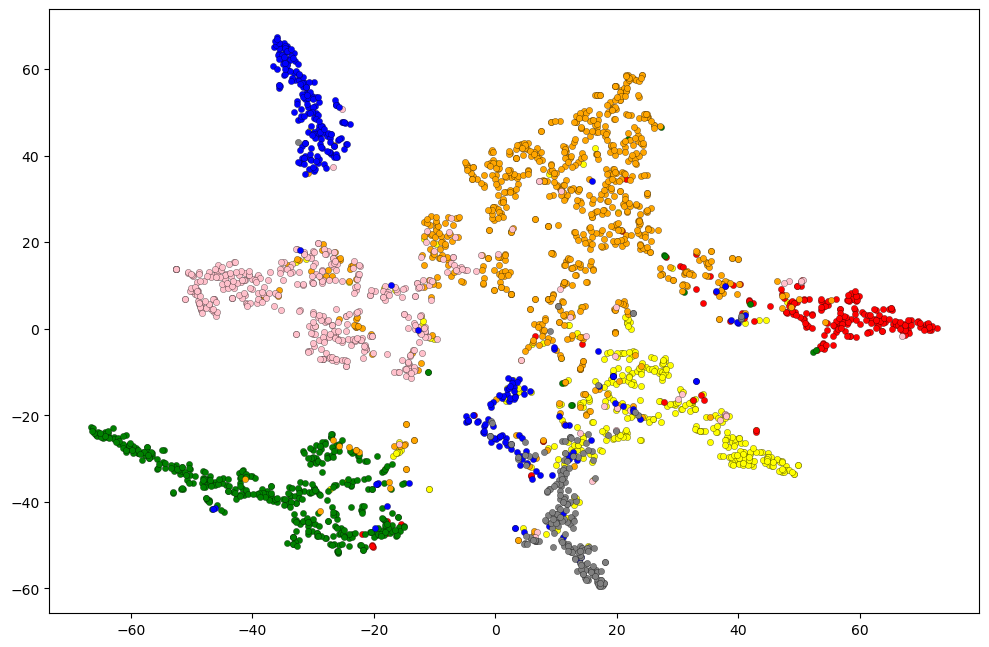

In [164]:
visualize_gat_properties(trainer_gat,visualization_type='tsne')

Sa grafika vidimo da je naš model odradio odličan posao

In [166]:
visualize_gat_properties(trainer_gat,visualization_type='entropy')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8 but corresponding boolean dimension is 2708